#  Supplementary Experiments for Rebuttal ICML 2025

This notebook provides a discussion on the quality of density ratio estimator. We will first give a description for the dataset, and then illustrates the results.

In [3]:
import numpy as np
from tqdm.notebook import tqdm
from utils import mean_confidence_interval
from utils import run_exp
from threadpoolctl import threadpool_limits
from utils import plot_multiple_weighted_qq

**1. Synthetic dataset formulation**

We consider here the same kind synthetic dataset in our paper, with the following process:
$$X \sim \mathcal{N}(\mu_X, \Sigma_X), \quad X \in \mathbb{R}^d $$
$$Y \mid X = \beta^\top X + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

Under this condition, we can write for the joint distribution of $(X,Y)$ which follows $\mathcal{N}(\mu_{XY}, \Sigma_{XY})$:
$$\mu_{XY} = \begin{bmatrix} \mu_X \\ \beta^\top \mu_X \end{bmatrix}$$

$$\Sigma_{XY} = \begin{bmatrix}\Sigma_X & \Sigma_X \beta \\ \beta^\top \Sigma_X & \beta^\top \Sigma_X \beta + \sigma^2 \end{bmatrix}$$

We suppose MCAR on X, so as to compute the all the density (ratio), each feature $X_j$ independently missing with probability 50\%. Denote missingness indicator by $M \in \{0, 1\}^d$, with $M_j = 1$ indicating $X_j$ is missing.

**2. Conditional distribution of missing covariates**

Using the properties of gaussian vector, we can have:
$$X _{\text{mis}} \mid X _{\text{obs}}, Y \sim \mathcal{N}(\mu _{\text{mis}\mid \text{obs}, Y}, \Sigma _{\text{mis}\mid \text{obs}, Y})$$
With:

$$\mu_{\text{mis}\mid \text{obs}, Y} = \mu_{\text{mis}} + \Sigma_{\text{mis}, [X_{\text{obs}}, Y]} \Sigma_{[X_{\text{obs}}, Y]}^{-1} \left( \begin{bmatrix} X_{\text{obs}} \ Y \end{bmatrix} - \mu_{[X_{\text{obs}}, Y]} \right)$$

$$\Sigma_{\text{mis}\mid \text{obs}, Y} = \Sigma_{\text{mis}, \text{mis}} - \Sigma_{\text{mis}, [X_{\text{obs}}, Y]} \Sigma_{[X_{\text{obs}}, Y]}^{-1} \Sigma_{[X_{\text{obs}}, Y], \text{mis}}$$

**3. Perturbed Imputation Strategy**

To simulate real scenorio where we always have estimation error of the missing distribution for imputation function. Here we perturb the mean and variance for imputation:

$$\varphi(x_m,y)_{mis(m)} \sim \mathcal{N}(\tilde{\mu}{_\text{mis(m)}}, \tilde{\Sigma}_{m})$$

Where:

$$\tilde{\mu}_{\text{mis}} = \alpha_m \cdot \mu_{\text{mis}\mid \text{obs}, Y} + \Delta_m$$

$$\tilde{\Sigma}_{\text{mis}}= \Sigma_{\text{mis}\mid \text{obs}, Y} + \tau_m I$$

With $\alpha > 0$, $\Delta \in \mathbb{R}^{|\text{mis}|}$, $\tau > 0$. Therefore, the density of $(\varphi(X_M),Y)$ can be computed explicitly by a mixture gaussian.

**4. Density ratio estimation**

We have defined in our paper the likelihood ratio conditional on a given mask $\omega_m(x_{\text{obs}(m)},y):=
    \frac{d\mathcal{P}_m(x_{\text{obs}(m)},y)}{d\mathcal{P}^{\varphi}_m(x_{\text{obs}(m)},y)}. $
In our example,$\mathcal{P}_m$ is the marginal distribution of $(X,Y)$ (still gaussian) and $\mathcal{P}^{\varphi}_m$ is the marginal distribution of $(\varphi(X_M),Y)$ (still mixture gaussian), by marginalizing both the missing covariates. Thus, the true density ratio can also be computed explicitly.


**5. Example in this notebook**

To compute efficiently the likelihood ratio, we consider $d=5$. $\mu_X=1$ and $\Sigma_X=\rho(1, \cdots, 1)^{T}(1, \cdots, 1)+(1-\rho) I_{d}$, with $\rho =0.8$. $\beta=[1,2,-1,3,-0.5]$ and $\sigma=1$. We have 500 training data, 200 calibration data, and 100 test data for a given mask $m_{\text{test}}=[1,1,1,0,0]$. We fix one $M_{\text{test}}$ to better compare the results on the coverage $P(Y\in C(X_M)|M=m_{\text{test}})$. The $m_{\text{test}}$ can be changed and our conclusion remains the same.

In [4]:
alpha = 0.1
d = 5
mu = np.ones(d)
rho = 0.8
Sigma = np.full((d, d), rho) + (1 - rho) * np.eye(d)

beta=np.array([1, 2, -1, 3, -0.5])
beta = beta[:d]

m_test = np.array([1,1,1,0,0])
# M_lr = np.array([1,1,1,0,1])

M_index = [i for i, val in enumerate(m_test) if val == 1]
obs_index = [i for i, val in enumerate(m_test) if val == 0]

cal_num = 200
test_num = 100

**6. Experiments**

For each setting, we repeat 100 experiments to compute a confidence interval for all the results.

**6.1 We pre-imputate the calibration data, and we apply directly the Split CP**

Obviously, there is a distribution shift conditional on $M_{test}$, and we observe a miscoverage.

In [3]:
covs = []
for seed in tqdm(range(100)):
    covs.append(run_exp(seed, mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test))
covs = np.array(covs)
mean, lower, upper = mean_confidence_interval(covs)
print(f"Average coverage without correction = {mean:.2f}, with 95% CI of the coverage = ({lower:.2f}, {upper:.2f})")

  0%|          | 0/100 [00:00<?, ?it/s]

Average coverage without correction = 0.86, with 95% CI of the coverage = (0.85, 0.87)


**6.2 We pre-imputate the calibration data, and we use the ground truth density ratio, applying the Weight CP techniques in our paper to correct this shift**

Obviously, the distribution shift conditional on $M_{test}$ is corrected and we observe an exact coverage.

In [4]:
covs = []
for seed in tqdm(range(100)):
    covs.append(run_exp(seed, mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test,
                        reweight=True, estimation_reweight=False))
covs = np.array(covs)
mean, lower, upper = mean_confidence_interval(covs)
print(f"Average coverage with oracle correction = {mean:.2f}, with 95% CI of the coverage = ({lower:.2f}, {upper:.2f})")

  0%|          | 0/100 [00:00<?, ?it/s]

Average coverage with oracle correction = 0.89, with 95% CI of the coverage = (0.88, 0.90)


**6.3 We pre-imputate the calibration data, and we use our Algorithm 2 to estimate the density ratio, then applying the Weight CP techniques in our paper to correct this shift**

Empirically, we observe a slightly over-coverage. But the coverage is guaranteed.

In [5]:
with threadpool_limits(limits=32):
    covs = []
    estimate_lr = []
    true_lr = []
    for seed in tqdm(range(100)):
        cov, es_lr, tr_lr, _ = run_exp(seed,  mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test,
                                       reweight=True, estimation_reweight=True)
        covs.append(cov)
        estimate_lr.append(es_lr.reshape(-1))
        true_lr.append(tr_lr.reshape(-1))
    covs = np.array(covs)
    estimate_lr = np.array(estimate_lr)
    true_lr = np.array(true_lr)
    mean, lower, upper = mean_confidence_interval(covs)
    print(f"Average coverage with estimated correction = {mean:.2f}, with 95% CI of the coverage = ({lower:.2f}, {upper:.2f})")

  0%|          | 0/100 [00:00<?, ?it/s]

Average coverage with estimated correction = 0.93, with 95% CI of the coverage = (0.92, 0.93)


**6.4 We pre-imputate the calibration data, and we use our Algorithm 2 to estimate the density ratio, but we add different noise to represent different quality of estimator of density ratio**

This means that, for each experiment, we have a different quality of estimation of density ratio.
- First, we observe the random noise on estimation of density ratio influences the average coverage, meaning that the correction fails.
- Second, for each experiment, we use Pearson coefficient to represent the quality of density ratio, and for each experiment, we can have a different coverage. Then we do a scatter of the (coverage-quality), so investigate how the quality of estimation of density ratio influences the coverage results.

In [21]:
with threadpool_limits(limits=32):
    covs = []
    estimate_lr = []
    true_lr = []
    error_lr = []
    for seed in tqdm(range(20)):
        cov, es_lr, tr_lr, er_lr = run_exp(seed,  mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test,
                                           reweight=True, estimation_reweight=True, estimation_random_noise=True,
                                           random_noise=0.5)
        covs.append(cov)
        estimate_lr.append(es_lr.reshape(-1))
        true_lr.append(tr_lr.reshape(-1))
        error_lr.append(er_lr)
    for seed in tqdm(range(20)):
        seed = seed + 20
        cov, es_lr, tr_lr, er_lr = run_exp(seed,  mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test,
                                           reweight=True, estimation_reweight=True, estimation_random_noise=True,
                                           random_noise=1.)
        covs.append(cov)
        estimate_lr.append(es_lr.reshape(-1))
        true_lr.append(tr_lr.reshape(-1))
        error_lr.append(er_lr)
    for seed in tqdm(range(20)):
        seed = seed + 40
        cov, es_lr, tr_lr, er_lr = run_exp(seed,  mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test,
                                           reweight=True, estimation_reweight=True, estimation_random_noise=True,
                                           random_noise=2)
        covs.append(cov)
        estimate_lr.append(es_lr.reshape(-1))
        true_lr.append(tr_lr.reshape(-1))
        error_lr.append(er_lr)
    for seed in tqdm(range(20)):
        seed = seed + 60
        cov, es_lr, tr_lr, er_lr = run_exp(seed,  mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test,
                                           reweight=True, estimation_reweight=True, estimation_random_noise=True,
                                           random_noise=3)
        covs.append(cov)
        estimate_lr.append(es_lr.reshape(-1))
        true_lr.append(tr_lr.reshape(-1))
        error_lr.append(er_lr)
    for seed in tqdm(range(20)):
        seed = seed + 80
        cov, es_lr, tr_lr, er_lr = run_exp(seed,  mu, Sigma, beta, cal_num, M_index, obs_index, alpha,test_num, m_test,
                                           reweight=True, estimation_reweight=True, estimation_random_noise=True,
                                           random_noise=4)
        covs.append(cov)
        estimate_lr.append(es_lr.reshape(-1))
        true_lr.append(tr_lr.reshape(-1))
        error_lr.append(er_lr)
    covs = np.array(covs)
    estimate_lr = np.array(estimate_lr)
    true_lr = np.array(true_lr)
    error_lr = np.array(error_lr)
    mean, lower, upper = mean_confidence_interval(covs)
    print(f"Mean = {mean:.2f}, 95% CI = ({lower:.2f}, {upper:.2f})")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Mean = 0.84, 95% CI = (0.81, 0.86)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


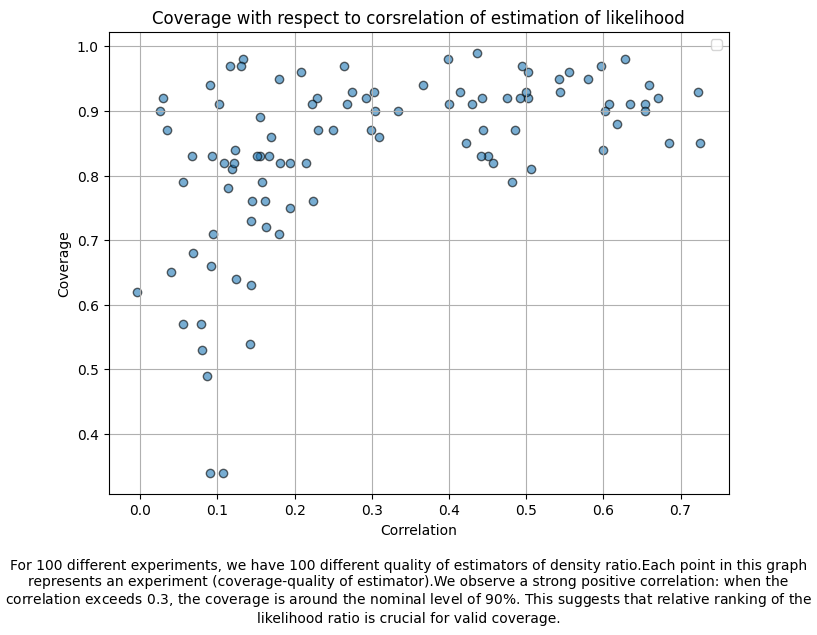

In [28]:
import matplotlib.pyplot as plt
correlations = []
for i in range(len(true_lr)):
    correlations.append(np.corrcoef(estimate_lr[i], true_lr[i])[0, 1])

plt.figure(figsize=(8, 6))
plt.scatter(correlations, covs, alpha=0.6, edgecolors='k')

plt.xlabel('Correlation')
plt.ylabel('Coverage')
plt.title('Coverage with respect to corsrelation of estimation of likelihood')
plt.legend()
plt.grid(True)
caption_text = (
    "For 100 different experiments, we have 100 different quality of estimators of density ratio."
    "Each point in this graph represents an experiment (coverage-quality of estimator)."
    "We observe a strong positive correlation: when the correlation exceeds $0.3$, the coverage is around the nominal level of $90\\%$. "
    "This suggests that relative ranking of the likelihood ratio is crucial for valid coverage."
)
plt.figtext(0.5, -0.1, caption_text, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

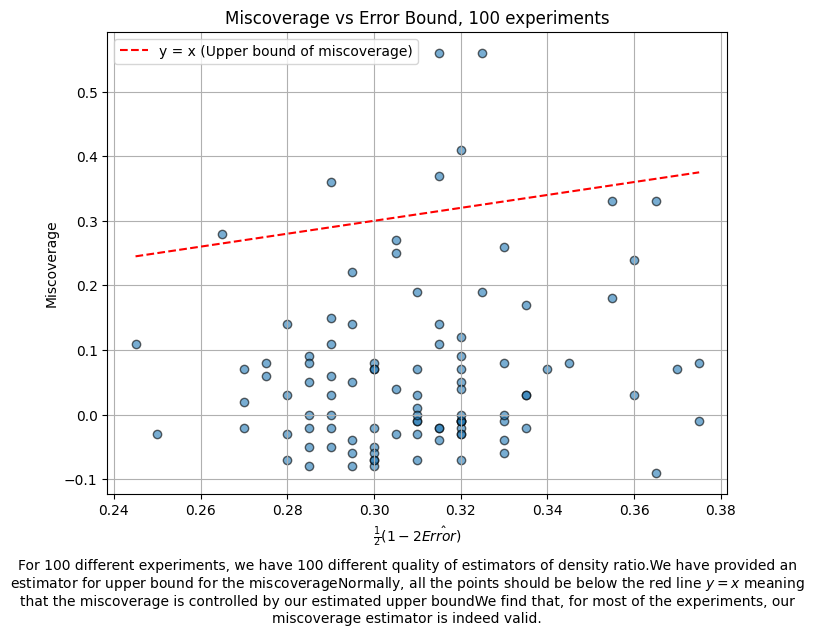

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(0.5*(1-2*error_lr), 1-alpha-covs, alpha=0.6, edgecolors='k')
x_min = min(0.5 * (1 - 2 * np.array(error_lr)))
x_max = max(0.5 * (1 - 2 * np.array(error_lr)))
x_vals = np.linspace(x_min, x_max, 100)
plt.plot(x_vals, x_vals, 'r--', label='y = x (Upper bound of miscoverage)')

plt.xlabel(r'$\frac{1}{2}(1-2\hat{Error})$')
plt.ylabel('Miscoverage')
plt.title('Miscoverage vs Error Bound, 100 experiments')
plt.legend()
plt.grid(True)
caption_text = (
    "For 100 different experiments, we have 100 different quality of estimators of density ratio."
    "We have provided an estimator for upper bound for the miscoverage"
    "Normally, all the points should be below the red line $y=x$ meaning that the miscoverage is controlled by our estimated upper bound"
    "We find that, for most of the experiments, our miscoverage estimator is indeed valid."
)
plt.figtext(0.5, -0.1, caption_text, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


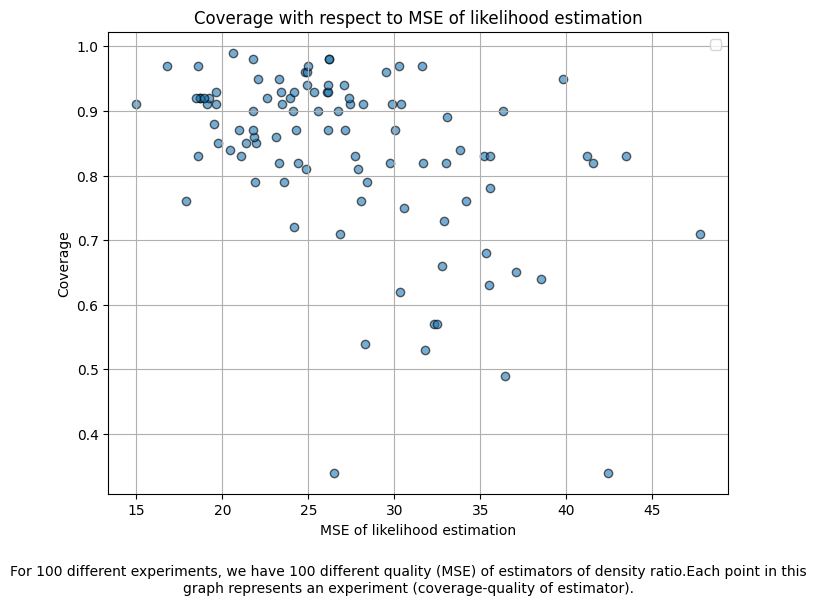

In [34]:
import matplotlib.pyplot as plt
def log_mse(lr_pred, lr_true):
    log_pred = np.log(lr_pred + 1e-12)
    log_true = np.log(lr_true + 1e-12)
    return np.mean((log_pred - log_true) ** 2)

errors = []
for i in range(len(true_lr)):
    errors.append(log_mse(estimate_lr[i]/sum(estimate_lr)*sum(true_lr), true_lr[i]))

plt.figure(figsize=(8, 6))
plt.scatter(errors, covs, alpha=0.6, edgecolors='k')

plt.xlabel('MSE of likelihood estimation')
plt.ylabel('Coverage')
plt.title('Coverage with respect to MSE of likelihood estimation')
plt.legend()
caption_text = (
    "For 100 different experiments, we have 100 different quality (MSE) of estimators of density ratio."
    "Each point in this graph represents an experiment (coverage-quality of estimator)."
)
plt.figtext(0.5, -0.05, caption_text, wrap=True, horizontalalignment='center', fontsize=10)
plt.grid(True)
plt.show()